# Sea Ice Concentration, Edge, and Lake Ice Cover from AMSR2 TB data

**Authors**: T. Lavergne (METNO)

Demonstration notebook [DD-JNB] V1 prepared for Preliminary Design Review (PDR) in the CIMR L2PAD project. Updated (V2D) for TC#2 by adding a section on Lake Ice Cover.

This notebook demonstrates tuning and application of the SIC, SIED, and LIC algorithm on daily gridded TB data from the AMSR2 mission.


In [1]:
import os, sys
from importlib import reload

import xarray as xr
import numpy as np

from collections import OrderedDict

from matplotlib import pylab as plt
import matplotlib.image as img

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean
import copy

import pyresample as pr

import json

In [2]:
if '/algorithm/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../algorithm'))

# software modules to implement the SIC algorithm
from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp
from pmr_sic import hybrid_algo
from pmr_sic import algo as single_algo
from pmr_sic import common

# software modules to implement the pan-sharpening algorithm
from pansharpen import pansharpen_gridded

Create a data directory to hold temporary and output files that are created by the notebook.

In [3]:
out_dir = os.path.abspath('../data') + '/output/DD-JNB_out'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

## Locate DI-TDS-JNB

The input data for this notebook are organized under [DI-TDS-JNB] (Test Data Set for Jupyter NoteBook). The default is to access this TDS online through thredds / opendap unless the environment variable `CIMR_L2PAD_JNB_TDS` is set. If it is set, it is the path to a local copy of the TDS.

We access both daily gridded AMSR2 TBs, and a static land mask (ADF) in a separate file.

In [4]:
try:
    tds_root = os.environ["CIMR_L2PAD_JNB_TDS"]
    print("Use local TDS: {}".format(tds_root))
except KeyError:
    tds_root = 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D'
    print("Use online TDS: {}".format(tds_root))


Use online TDS: https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D


In [5]:
tds_files = dict()
tds_files['nh'] = tds_root + "/AMSR2_DAILY_POLAR/tc_amsr2-gw1_{}_ease2-125_2020033112.nc".format('nh',)
tds_files['sh'] = tds_root + "/AMSR2_DAILY_POLAR/tc_amsr2-gw1_{}_ease2-125_2020043012.nc".format('sh',)

lmask_files = dict()
lmask_files['nh'] = tds_root + "/SUPPORTING_DATA/icemask-multi-{}-ease2-125-2020033112.nc".format('nh',)
lmask_files['sh'] = tds_root + "/SUPPORTING_DATA/icemask-multi-{}-ease2-125-2020043012.nc".format('sh',)

print("Files with input TBs:\n", tds_files)
print()
print("Files with ADF (Static Land Masks):\n", lmask_files)

Files with input TBs:
 {'nh': 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D/AMSR2_DAILY_POLAR/tc_amsr2-gw1_nh_ease2-125_2020033112.nc', 'sh': 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D/AMSR2_DAILY_POLAR/tc_amsr2-gw1_sh_ease2-125_2020043012.nc'}

Files with ADF (Static Land Masks):
 {'nh': 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D/SUPPORTING_DATA/icemask-multi-nh-ease2-125-2020033112.nc', 'sh': 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D/SUPPORTING_DATA/icemask-multi-sh-ease2-125-2020043012.nc'}


In [6]:
ds = dict()
for area in ('nh', 'sh'):
    ds[area] = xr.open_dataset(tds_files[area])

lmask = dict()
for area in ('nh', 'sh'):
    lmask[area] = xr.open_dataset(lmask_files[area])

adef = dict()
for area in ('nh', 'sh'):
    adef[area],_ = pr.utils.load_cf_area(ds[area])

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Use the land mask to mask out the TBs over land (the TBs are already filled with nans over land, but the landmask makes a cleaner masking in the coastal regions.

In [7]:
for area in ('nh', 'sh'):
    lmask_bool = lmask[area]['ice_edge'][0].values!=np.nan
    for var in ds[area].variables:
        if var.startswith('tb'):
            ds[area][var] = ds[area][var].where(lmask_bool)

Display the TB images

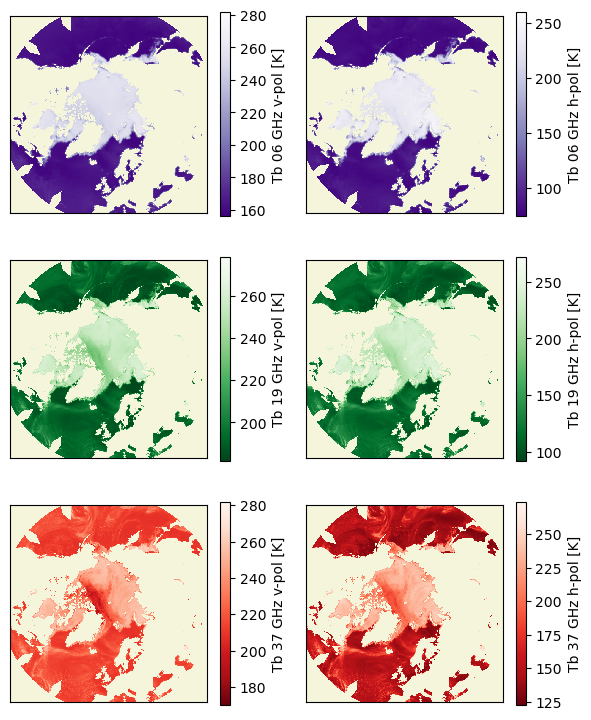

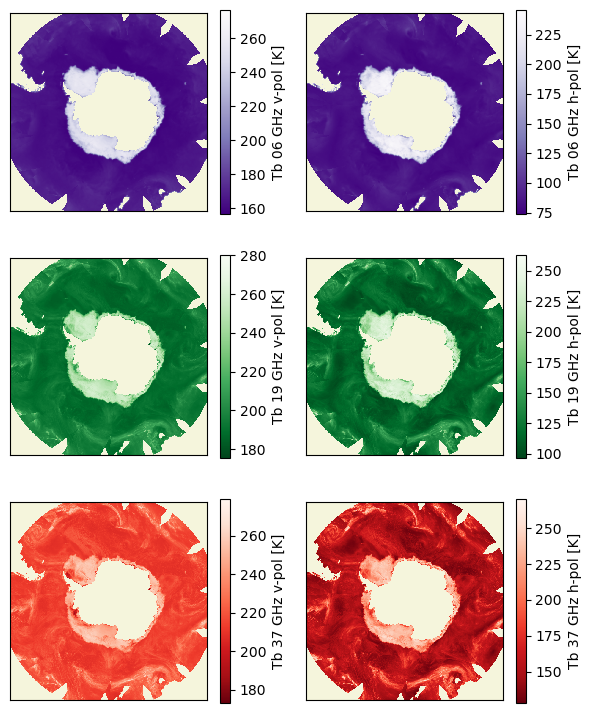

In [8]:
cmaps = {'06': 'Purples_r', '19': 'Greens_r', '37': 'Reds_r'}
 
for area in ('nh', 'sh'):
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(7,9), sharex=True, sharey=True)

    for ifreq, freq in enumerate(('06', '19', '37')):
        cmap = copy.copy(plt.colormaps[cmaps[freq]])
        cmap.set_bad('beige')
        for ipol, pol in enumerate(('v', 'h')):
            ax = axs[ifreq,ipol]
            vname = 'tb' + freq + pol
            c = ax.imshow(ds[area][vname][0], interpolation='none', cmap=cmap)
            ax.set_xticks([]); ax.set_yticks([]);
            cbar = plt.colorbar(c, orientation='vertical', ax=ax)
            cbar.set_label(ds[area][vname].long_name + ' [K]')

    plt.show()

## Define the SIC algorithms

The CIMR Level-2 Sea Ice Concentration algorithm is based on operating several algorithms and combining their resulting fields into a final SIC variable (among others using a pan-sharpening algorithm).

We first define the 3 algorithms that will be run: `CKA`, `KKA`, and `KA`:

* `CKA` uses brightness temperatures in C-band (6.9 GHz) V-pol, as well as Ka-band (36.5 GHz) at V- and H-pol. It is the most accurate SIC algorithms of the three, but has the coarsest resolution because of the use of C-band.
* `KKA` uses brightness temperatures in K-band (18.7 GHz) V-pol, as well as Ka-band (36.5 GHz) at V- and H-pol. It is less accurate but higher resolution than `CKA`.
* `KA` uses brightness temperatures in Ka-band (36.5 GHz) only, both at V- and H-pol. It has the highest resolution, but is the least accurate of the three, by a significant margin.



In [9]:
algos = OrderedDict()
algos['CKA'] = {'channels':('tb06v', 'tb37v', 'tb37h'), 'target_band':'C'}
algos['KKA'] = {'channels':('tb19v', 'tb37v', 'tb37h'), 'target_band':'KA'}
algos['KA'] = {'channels':('tb37v', 'tb37h'),  'target_band':'KA'}

channels_needed = []
for alg in algos.keys():
    channels_needed += algos[alg]['channels']
channels_needed = set(channels_needed)

## Offline preparation : tune the SIC algorithms

We tune the SIC algorithms to the $T_B$ data itself. In the future operational implementation, the tuning will be repeated on a daily basis (with a sliding window) and directly on the CIMR brightness temperatures. This requires access to a rolling archive of L1B files (typically 5-10 days worth of L1B files).

For the demonstration here, we tune the algorithm against the ESA CCI Sea Ice Concentration Round Robin Data Package (RRDP) of Pedersen et al. (2019). The relevant data files as well as routines to parse the files are stored in module `siddrp/`.

```{note}
Pedersen, Leif Toudal; Saldo, Roberto; Ivanova, Natalia; Kern, Stefan; Heygster, Georg; Tonboe, Rasmus; et al. (2019): Reference dataset for sea ice concentration. figshare. Dataset. https://doi.org/10.6084/m9.figshare.6626549.v7
```

In [10]:
# locate and read the RRDP files
rrdp_dir = os.path.abspath('../data') + '/CCI_SeaIce_RRDP/RRDP_v3.0/'

rrdp_pos_ow = dict()
rrdp_pos_ci = dict()
for area in ('nh', 'sh'):
    print("Locate and load RRDP for area {}".format(area.upper()))
    
    if area == 'nh':
        winter_months = [11, 12, 1, 2, 3, 4]
    elif area == 'sh':
        winter_months = [5, 6, 7, 8, 9, 10]

    # load OW (Open Water) samples from RRDP SIC0 files
    rrdp_pos_ow[area] = rrdp_file.load_rrdp_samples(rrdp_dir, 'AMSR2', area, 'ow',
                                     years=range(2016, 2020), months = winter_months,
                                     channels = channels_needed,
                                     max_sel=10000,with_nwp=False)

    for ch in channels_needed:
        print(ch, rrdp_pos_ow[area][ch].min(), rrdp_pos_ow[area][ch].max())

    # load CI (Closed Ice) samples from RRDP SIC1 files
    rrdp_pos_ci[area] = rrdp_file.load_rrdp_samples(rrdp_dir, 'AMSR2', area, 'cice',
                                     years=range(2016, 2020), months = winter_months,
                                     channels = channels_needed,
                                     max_sel=10000,with_nwp=False)

print("Done")

Locate and load RRDP for area NH
Select every 2 OW points
tb19v 181.55 223.99
tb06v 157.44 183.84
tb37h 128.21 236.7
tb37v 205.42 251.49
Select every 9 CICE points
Locate and load RRDP for area SH
Select every 1 OW points
tb19v 181.45 219.68
tb06v 157.11 175.69
tb37h 126.58 225.67
tb37v 205.91 246.73
Select every 2 CICE points
Done


The tuning is run for all 3 algorithms in turn, and the result is stored in a `.json` file (could be turned into a `.xml` file) in the GPP implementation.

In [11]:
# helper class to write dict() to .json
class MyEncoder(json.JSONEncoder):
    # https://stackoverflow.com/questions/27050108/convert-numpy-type-to-python/27050186#27050186
    def default(self, obj):
        if isinstance(obj, int):
            return int(obj)
        elif isinstance(obj, float):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [12]:
# run the tuning for each algorithm in turn.
for area in ('nh', 'sh'):
    print("Tune SIC algorithms for area {}".format(area.upper()))
    for alg in algos.keys():
    
        # Transfer the training data in a tie-point object. This involves some processing,
        #  like computing the tie-points and their covariance matrices. 
        ow_tp = tp.OWTiepoint(source='tbs', tbs=rrdp_pos_ow[area], channels=algos[alg]['channels'])
        ci_tp = tp.CICETiepoint(source='tbs', tbs=rrdp_pos_ci[area], channels=algos[alg]['channels'])
        ow_tp.instr = ci_tp.instr = 'CIMR'
        ow_tp.source = ci_tp.source = 'CCI-RRDP'
    
        # Tune the SIC algorithm on these tie-points
        tuned_algo = hybrid_algo.HybridSICAlgo(algos[alg]['channels'], ow_tp, ci_tp)
    
        # Store the algorithm on disk (JSON file) for later re-use
        json_fn = os.path.join(out_dir,'{}_{}_sic_{}.json'.format(alg.upper(), area.upper(), ow_tp.source.upper()))
        with open(json_fn, 'w') as fp_out:
            json.dump(tuned_algo.strip().to_dict(), fp_out, indent=4, sort_keys=True, cls=MyEncoder)

        print("{} SIC configuration file is in {}".format(alg, json_fn))

Tune SIC algorithms for area NH
CKA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CKA_NH_sic_CCI-RRDP.json
KKA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KKA_NH_sic_CCI-RRDP.json
KA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KA_NH_sic_CCI-RRDP.json
Tune SIC algorithms for area SH
CKA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CKA_SH_sic_CCI-RRDP.json
KKA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KKA_SH_sic_CCI-RRDP.json
KA SIC configuration file is in /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KA_SH_sic_CCI-RRDP.json


## Run the `CKA`, `KKA`, and `KA` SIC algorithms on the TB maps

Once the `CKA`, `KKA`, and `KA` SIC algorithms are tuned (see above), we load them from their `.json` files and apply them on the maps of $T_B$ from the Test Data Set. Because we used the AMSR section of the RRDP, we actually tuned the algorithms to the same $T_B$s (wavelength, calibration, etc...) we apply them to. This is critical to reduce retrieval biases.

First, we load the algorithms from their `.json` representation, and store the algorithm object into a python dictionary.

In [13]:
for alg in algos.keys():
    algos[alg]['algo'] = dict()
    for area in ('nh', 'sh'):
        # load 1 tune SIC algo
        json_fn = os.path.join(out_dir,'{}_{}_sic_{}.json'.format(alg.upper(), area.upper(), 'CCI-RRDP'))
        print("Load tuned {} algo from {}".format(alg, json_fn))
        if not os.path.exists(json_fn):
            raise ValueError("Cannot find .json parameter file for {} {} SIC:\n\t{}".format(area.upper(), alg, json_fn))
    
        with open(json_fn) as fp:
            algo_sic_params = json.load(fp)
                                    
        algo_sic_params = common.numpify(algo_sic_params)
        algos[alg]['algo'][area] = hybrid_algo.HybridSICAlgo.from_dict(algo_sic_params)

Load tuned CKA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CKA_NH_sic_CCI-RRDP.json
Load tuned CKA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CKA_SH_sic_CCI-RRDP.json
Load tuned KKA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KKA_NH_sic_CCI-RRDP.json
Load tuned KKA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KKA_SH_sic_CCI-RRDP.json
Load tuned KA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KA_NH_sic_CCI-RRDP.json
Load tuned KA algo from /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/KA_SH_sic_CCI-RRDP.json


Prepare the $T_B$s in a format that the algorithms can ingest: a python dictionary with all bands.

In [14]:
tbs = dict()
for area in ('nh', 'sh'):
    tbs[area] = dict()
    for ch in channels_needed:
        tbs[area][ch] = ds[area][ch][0].values

Now run the SIC algorithms on the $T_B$s and store the results. The results object holds both the sea-ice concentration, the uncertainty, the Open Water Filter (OWF), and the Distance Along the Line (a by-product of the algorithm).

In [15]:
sic_res = dict()
for alg in algos.keys():
    sic_res[alg] = dict()
    for area in ('nh', 'sh'):
        sic_res[alg][area] = algos[alg]['algo'][area].compute_sic(tbs[area])
        sic_res[alg][area].sic *= 100

We can visualize the maps of SIC, uncertainties, and OWF as computed by the three algorithms `CKA`, `KKA`, and `KA` algorithms.

In [16]:
def plot_sic_results(sic_res, ax = None, zoom=None, only_sic=False):
    if ax is None:
        if only_sic:
            fig, ax = plt.subplots(ncols=1, figsize=(6,6), sharex=True, sharey=True)
            ax = [ax,]
        else:
            fig, ax = plt.subplots(ncols=3, figsize=(13,4), sharex=True, sharey=True)

    if zoom is not None:
        shape = sic_res.sic.shape
        if zoom == 'zoom-nh':
            xlim = (330, 2*shape[1]//3)
            ylim = (3*shape[1]//4, 400)
        elif zoom == 'zoom-na':
            xlim = (0, 250)
            ylim = (3*shape[1]//4, 400)
        elif zoom == 'zoom-sh':
            xlim = (200, 450)
            ylim = (380, 100)
        else:
            raise ValueError("Unknown zoom {}".format(zoom))
    else:
        xlim = (None, None)
        ylim = (None, None)
    
    # Sea Ice Concentration
    cmap = copy.copy(cmocean.cm.ice); cmap.set_bad('beige')
    c = ax[0].imshow(sic_res.sic, interpolation='none', cmap=cmap, vmin=0, vmax=100)
    ax[0].set_xticks([]); ax[0].set_yticks([])
    ax[0].set_xlim(*xlim); ax[0].set_ylim(*ylim)
    cbar = plt.colorbar(c, ax=ax[0], orientation='vertical', shrink=0.75)
    cbar.set_label('(Raw) Sea Ice Concentration [%]')

    if only_sic:
        return ax
    
    # Sea Ice Concentration Uncertainty
    cmap = copy.copy(cmocean.cm.thermal); cmap.set_bad('beige')
    c = ax[1].imshow(sic_res.sdev, interpolation='none', cmap=cmap, vmin=0, vmax=10)
    cbar = plt.colorbar(c, ax=ax[1], orientation='vertical', shrink=0.75)
    cbar.set_label('SIC Uncertainty [%]')

    # Open Water Filter
    cmap = copy.copy(plt.cm.Reds_r,); cmap.set_bad('beige')
    c = ax[2].imshow(sic_res.owf, interpolation='none', cmap=cmap, vmin=0, vmax=1)
    cbar = plt.colorbar(c, ax=ax[2], orientation='vertical', shrink=0.75)
    cbar.set_label('Open Water Filter [1]')

    return ax

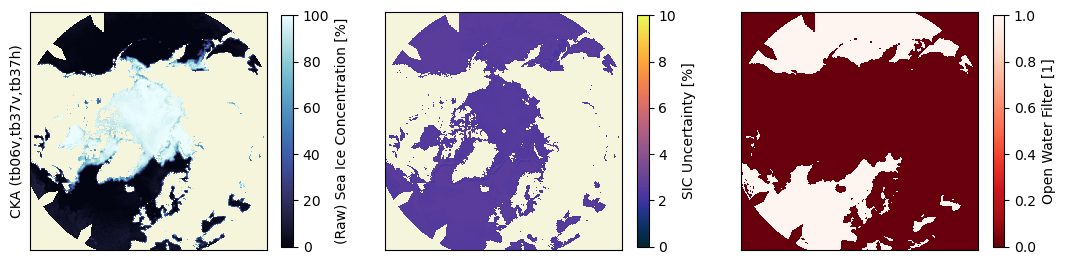

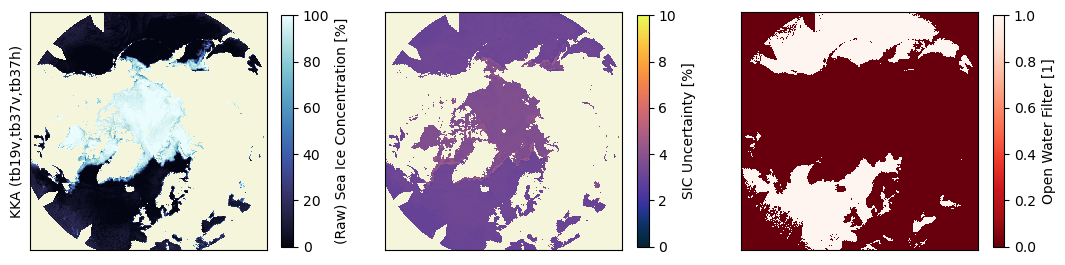

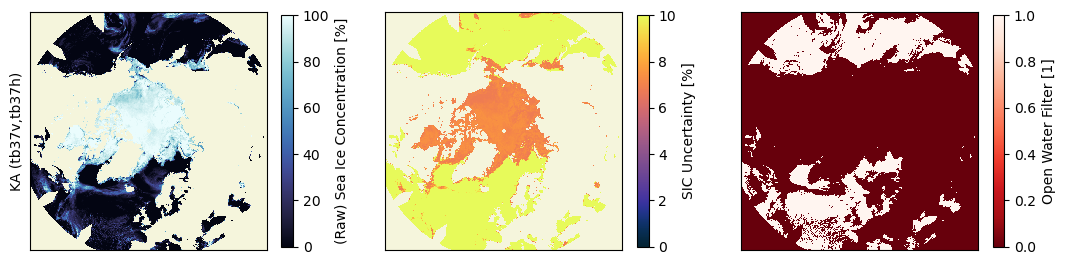

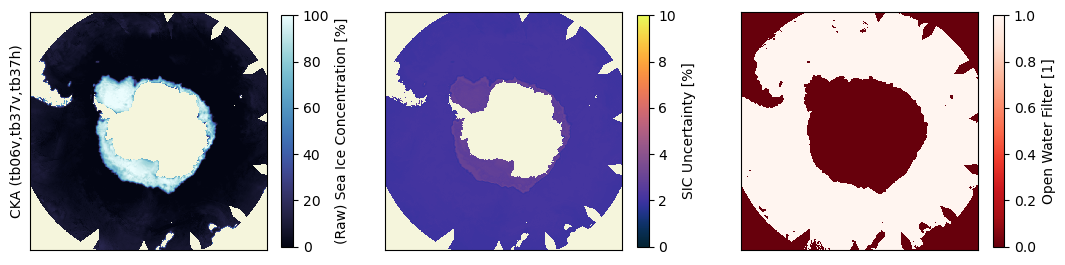

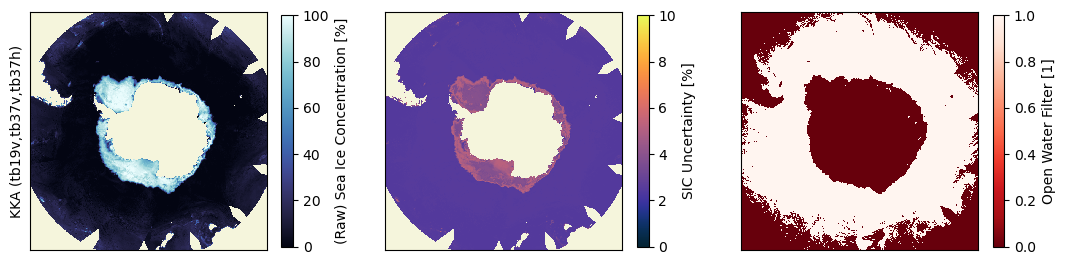

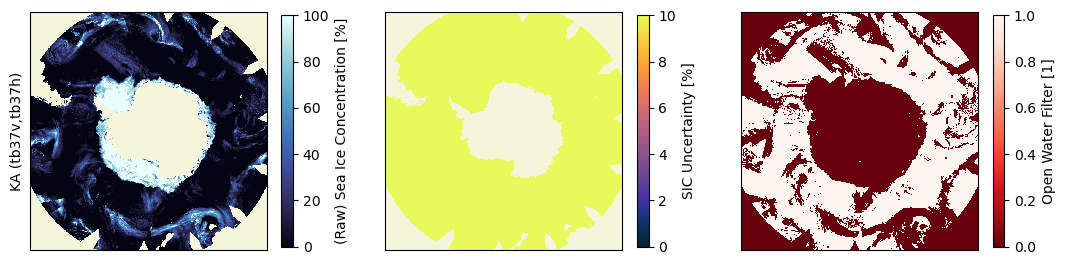

In [17]:
for area in ('nh', 'sh'):
    for alg in algos.keys():
        ax = plot_sic_results(sic_res[alg][area])
        ax[0].set_ylabel(alg + ' (' + ','.join(algos[alg]['channels']) + ')')
        plt.show()

These maps confirm the general expectations for the 3 algorithms: `CKA` has the lowest uncertainty (around 2%), `KKA` has intermediate uncertainty (around 3% over the ocean, and 4% over the ice). `KA` has high uncertainties, above 10%, even more so in the Southern Hemisphere. The large uncertainty in `KA` SICs translates into high values of the "raw" SIC fields where intense weather conditions are over the ocean, and large underestimation over the sea ice. The increased `KA` uncertainty in the Southern Hemisphere can be because the atmospheric wetness (vapour and liquid water) is higher there than in the Northern Hemisphere, combined with the lack of clear signature difference between first-year ice and multiyear ice.

The increase in uncertainty is reflected in the performance of the Open Water Filter. The Open Water Filter is True (value = 1) when the grid cell is detected as "probably water". The influence of the weather on the `KA` SICs is such that the `KA` Open Water Filter is almost unusable in both hemisphere (in practice, one would use the Open Water Filter of `KKA` to mask the `KA` SIC fields).

We can now zoom in to show the difference of spatial resolution between the various algorithms.

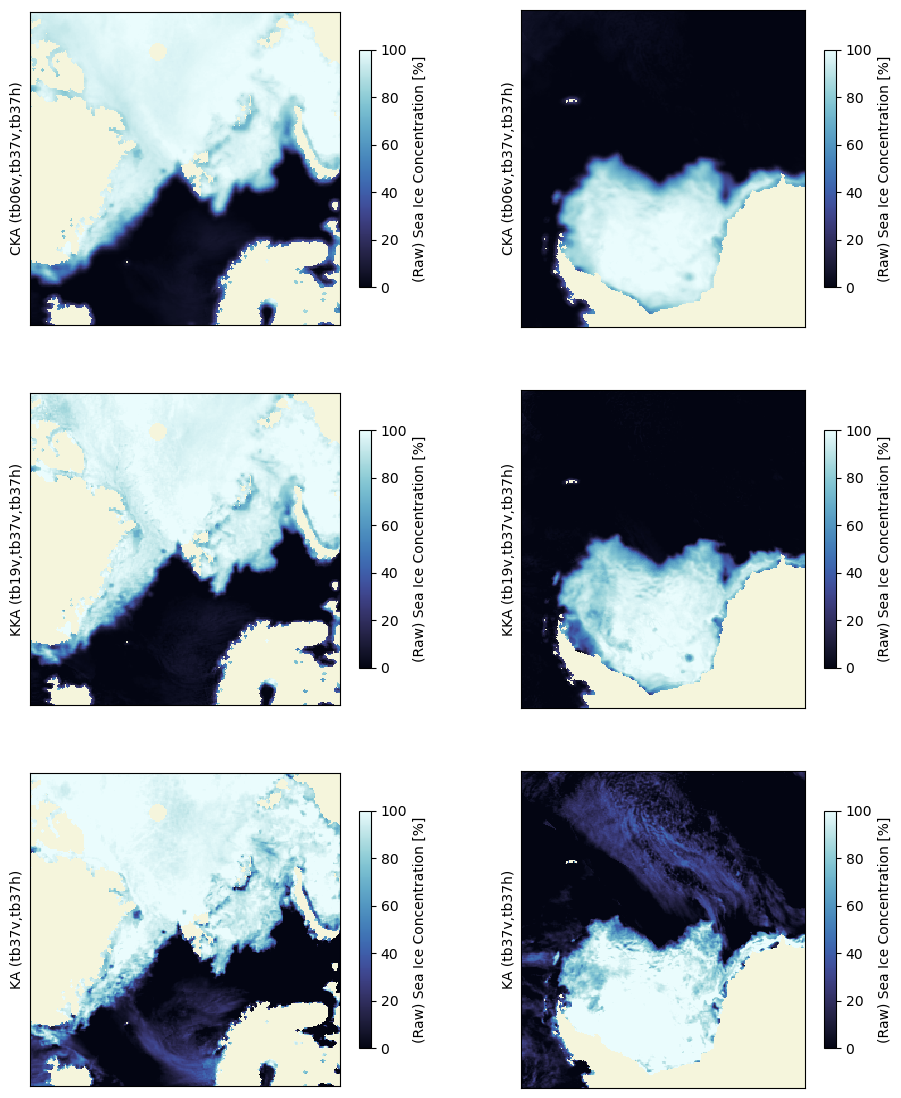

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(11,14))
for ii, area in enumerate(('nh', 'sh')):
    for ij, alg in enumerate(algos.keys()):
        ax = plot_sic_results(sic_res[alg][area], zoom='zoom-' + area, only_sic=True, ax=[axs[ij,ii],])
        ax[0].set_ylabel(alg + ' (' + ','.join(algos[alg]['channels']) + ')')

plt.show()

The results are as expected, with the `CKA` results being much coarser resolution than the `KKA` algorithm, in turn coarser resolution than the `KA` SIC. This is evident especially when looking at the details in the ice edge and along the coasts.

We note that the difference of resolution between the three algorithms is expected to be much less for CIMR than for shown with AMSR2 above. For example, the K and Ka channels of CIMR should have rather similar resolution (5 km vs 4 km) while the difference is larger with AMSR2 (20 km vs 10km). The C-band channel of CIMR will have 15 km resolution while that of AMSR2 has 45 km resolution. While running the algorithms on AMSR2 TBs is a useful illustration of the their main principles, the fine tuning of the CIMR Level-2 algorithm will in the future be based on simulated CIMR data, with the expected spatial resolution.


## Run the pan-sharpening algorithm

The results above are exactly as expected from the definition of the algorithms:

* `CKA` is the most accurate SIC algorithms of the three, but has the coarsest resolution because of the use of C-band.
* `KKA` is less accurate but higher resolution than `CKA`.
* `KA` has the highest resolution, but is the least accurate of the three, by a significant margin.

We can thus apply pan-sharpening algorithms combining two of the three SIC fields. Two pan-sharpened SIC fields can be relevant:
* `CKA@KA` : the `CKA` SICs sharpened with the details of the `KA` SICs;
* `CKA@KKA` : the `CKA` SICs sharpened with the details of the `KKA` SICs;

The second (`CKA@KKA`) will have coarser resolution than the first (`CKA@KA`) but will provide more accurate SICs in conditions where the `KA` algorithm returns grossly erroneous SICs. In this version of the notebook, we only show application of `CKA@KA`, which is the nominal choice.

The pan-sharpening algorithm has a simple form when the *base* (LR) and *sharpener* (HR) fields are already available on the same grids:
$$
SIC_{ER} = SIC_{LR} + (SIC_{HR} - SIC_{HR, blurred})
$$
where $SIC_{ER}$ is the resulting *Enhanced Resolution* SIC field.

The ATBD (section *Enhanced-resolution SICs using pan-sharpening*) has a more general formula in the case of swath processing when the *base* (LR) field is not in the same location nor resolution as the *sharpener* (HR) field.

In [19]:
reload(pansharpen_gridded)
sic_res['CKA@KA'] = dict()
for area in ('nh', 'sh'): 
    
    # Get the grid spacing (km) of the SIC field
    xc = ds[area]['xc'].values
    xres = abs(xc[1] - xc[0])
    
    # call the pansharpening module (for gridded SIC fields)
    sic_lr = sic_res['CKA'][area].sic
    sic_hr = sic_res['KA'][area].sic
    sic_er, sic_hr_blurred = pansharpen_gridded.blend_c(sic_lr, sic_hr, 'amsr', xres)

    # handle uncertainties and flags.
    # at this time, the uncertainty and OWF of the enhanced resolution fields
    #   are directly those of the low-resolution field.
    owf_er = sic_res['CKA'][area].owf
    sdev_er = sic_res['CKA'][area].sdev
    dal_er = sic_res['CKA'][area].dal
    
    # store the resulting SIC in a result object
    sic_res['CKA@KA'][area] = single_algo.SICAlgoResult(sic_er, sdev_er, owf_er, dal_er, )

Plot the SIC fields (LR, HR, and ER)

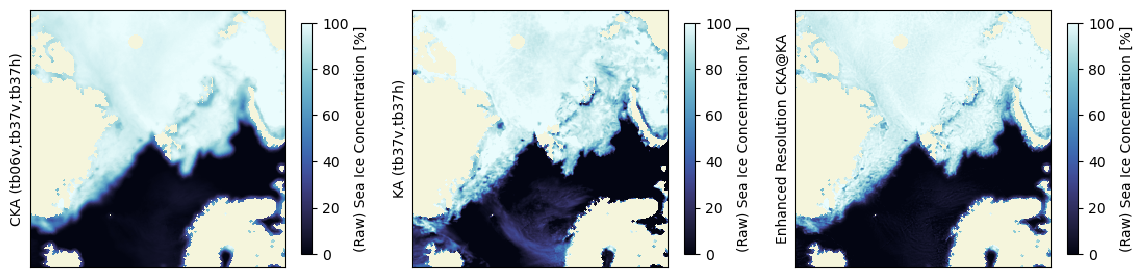

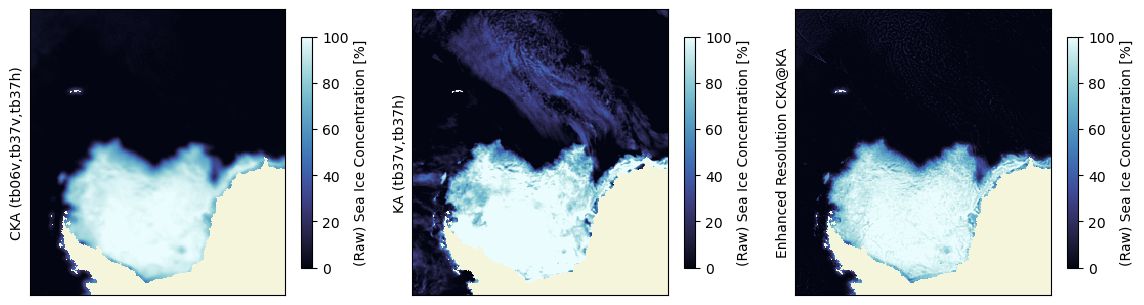

In [20]:
for area in ('nh', 'sh'):
    
    fig, axs = plt.subplots(ncols=3, figsize=(14,4))
    ax = plot_sic_results(sic_res['CKA'][area], zoom='zoom-' + area, only_sic=True, ax=[axs[0],])
    ax[0].set_ylabel('CKA' + ' (' + ','.join(algos['CKA']['channels']) + ')')
    ax = plot_sic_results(sic_res['KA'][area], zoom='zoom-' + area, only_sic=True, ax=[axs[1],])
    ax[0].set_ylabel('KA' + ' (' + ','.join(algos['KA']['channels']) + ')')
    ax = plot_sic_results(sic_res['CKA@KA'][area], zoom='zoom-' + area, only_sic=True, ax=[axs[2],])
    ax[0].set_ylabel('Enhanced Resolution CKA@KA')
    plt.show()
    

The illustration above demonstrate the effect of the pan-sharpening algorithm: the resulting *Enhanced Resolution* SIC field (right) presents finer details than the *Low Resolution* field (left), but not all the noise visible in the *High Resolution* field (middle). The pan-sharpening effectively enhanced the resolution of the *LR* field without introducing (all of) the noise from the *HR* field.

An attentive reader will notice that the *Enhanced Resolution* SIC field presents degraded SICs along the coastlines (with respect to the *HR* field). The pan-sharpening algorithm is indeed mostly work away from the coasts, where the computation of $SIC_{HR,blurred}$ is effective. Improving SICs in the coastal region will mainly come from:
1. using TBs corrected from the contamination of land emissivities (this is step in the L1B/L2 Bridge);
2. improve the pan-sharpening algorithm in the vicinity of land and coastlines (future R&D).

## Run the Sea Ice Edge algorithm

The Sea Ice Edge (SIED) product is obtained from the *Enhanced Resolution* SIC field by a simple thresholding (typically at 15% SIC). The computation of the SIED field is demonstrated below.

Note that the propagation of SIC uncertainties into the SIED field is future R&D. The routine below will later return both the SIED field and the uncertainty (a probability).

In [21]:
# the SIED algorithm is so simple that we implement it directly in the JNB. We will later move it to python module files.
def compute_sied(sic, owf, sdev, threshold=15.):
    sic[owf==1] = 0
    sied = (sic>=threshold).astype('short')
    sied = np.ma.array(sied, mask=np.isnan(sic))
    return sied

In [22]:
sied = dict()
for area in ('nh', 'sh'):
    sied[area] = compute_sied(sic_res['CKA@KA'][area].sic, sic_res['CKA@KA'][area].owf, sic_res['CKA@KA'][area].sdev)

Visualize the SIED fields

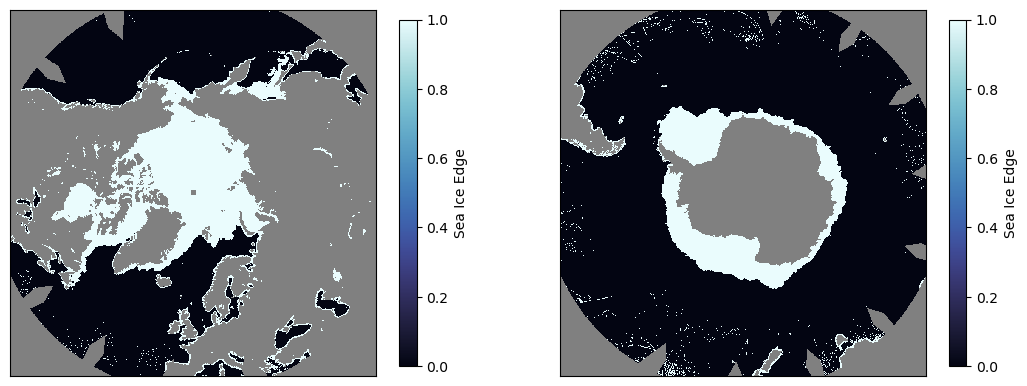

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(13,6), sharex=True, sharey=True)
for ia, area in enumerate(('nh', 'sh')):
    cmap = copy.copy(cmocean.cm.ice); cmap.set_bad('gray')
    c = ax[ia].imshow(sied[area], interpolation='none', cmap=cmap, vmin=0, vmax=1)
    ax[ia].set_xticks([]); ax[ia].set_yticks([])
    cbar = plt.colorbar(c, ax=ax[ia], orientation='vertical', shrink=0.75)
    cbar.set_label('Sea Ice Edge')

plt.show()

The maps above illustrate how the L2 SIED will be derived from L2 SIC. The SIED product can become an effective ice/no-ice mask for other L2 variables (within or outside the L2 GPP).

The reader will notice sea ice detected along many coastlines. This is a direct effect from the L2 SIC being overestimated along the coastlines. As discussed for SIC, this overestimation will be addressed by using land-corrected *L2PP* TBs as prepared in the L1B/L2 Bridge, and by applying maximum sea-ice extent masks (based on climatologies). The reader will also notice small pixels of sea ice detected in the open ocean and lower latitudes. These are residuals from atmospheric contamination and will be addressed both by using TB corrected for the atmospheric noise (as prepared in the L1B/L2 Bridge) and applying maximum sea-ice extent masks (based on climatologies). All these aspects will be developed in future versions of the ATBD. 

## Lake Ice Cover over the Great Lakes

JAXA AMSR2, even at K and Ka bands, has a coarse spatial resolution for monitoring Lake Ice Cover (LIC). Only the largest lakes like the Great Lakes and Caspian Sea are to some extent exploitable for fractional LIC, while smaller lakes present a high degree of land spill-over contamination.

Below, we visualize the results of the `KKa` algorithm above (thus tuned for Arctic sea ice) over the Great Lakes, and compare the result to the manual lake ice analysis performed by the U.S. National Ice Center (NIC). The NIC chart was accessed from [here](https://usicecenter.gov/Products/GreatLakesCharts).

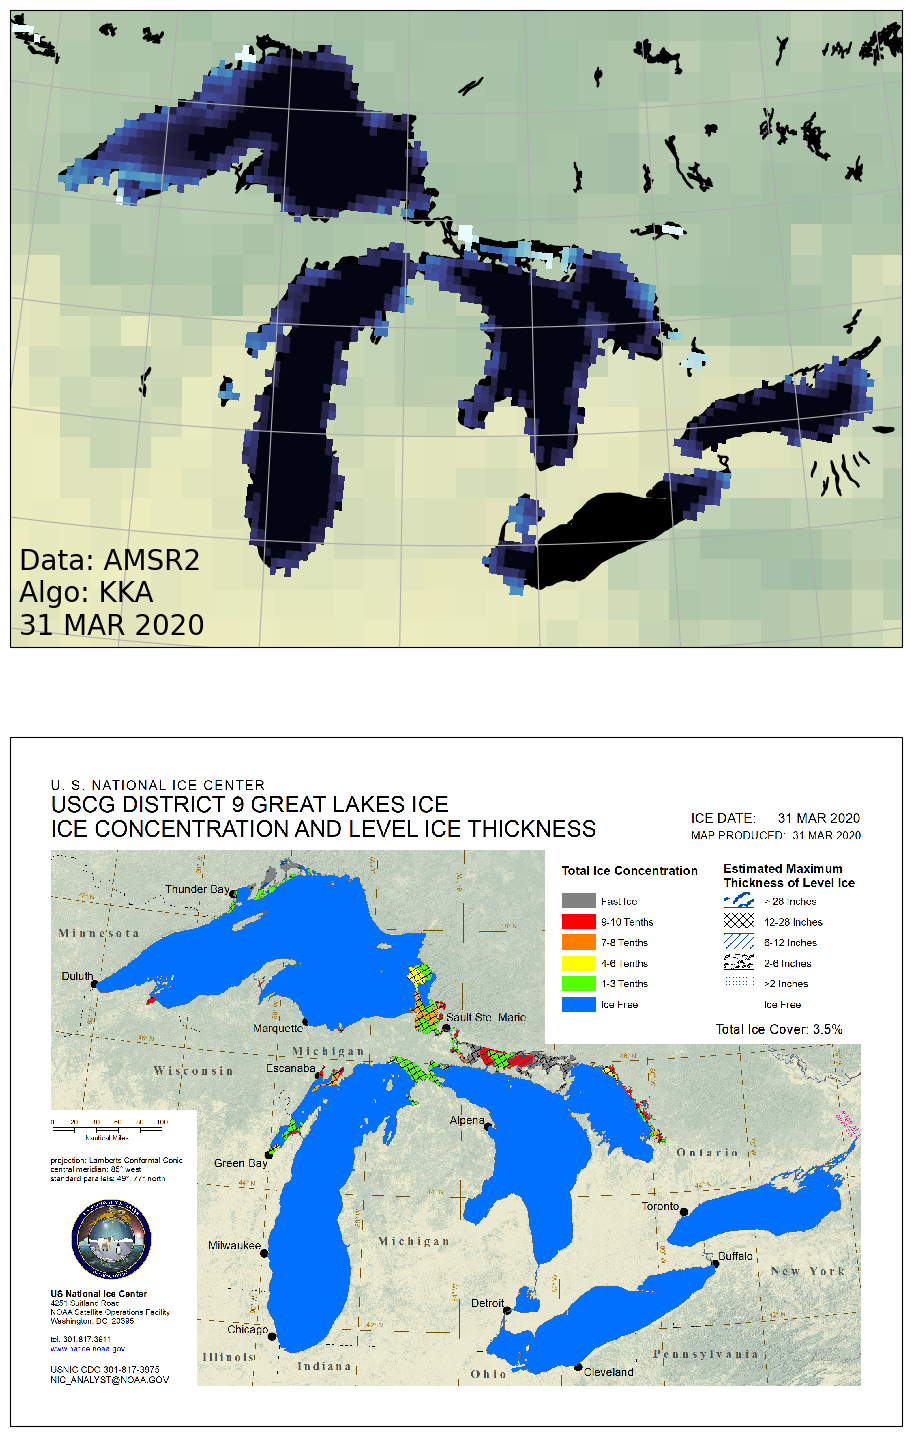

In [24]:
sic_crs = adef['nh'].to_cartopy_crs()
ccrs_great_lakes = ccrs.LambertConformal(central_longitude=-84, central_latitude=45, standard_parallels=(49, 77))

# SIC from KKA algorithm, with open water filter (OWF)
sic = sic_res['KKA']['nh'].sic
sic[sic_res['KKA']['nh'].owf] = 0

# Reference Lake Ice Cover from US National Ice Center (as png)
im = img.imread('../atbd/static_imgs/great_lake_seaice_20200331.png')

fig, ax = plt.subplots(nrows=2, subplot_kw=dict(projection=ccrs_great_lakes),
                       layout='constrained', figsize=(9,15))
ax[0].stock_img()
ax[0].add_feature(cfeature.COASTLINE, zorder=0)
ax[0].add_feature(cfeature.LAKES, edgecolor='black', facecolor='black', zorder=0)
ax[0].gridlines()
ax[0].text(0.01,0.01,'Data: AMSR2\nAlgo: KKA\n31 MAR 2020', fontsize=20, va='bottom', ha='left', transform=ax[0].transAxes)

ext = -600000
ax[0].set_xlim(-700000, 700000)
ax[0].set_ylim(-500000, 500000)

cmap = copy.copy(cmocean.cm.ice);
ax[0].imshow(sic, transform=sic_crs, extent=sic_crs.bounds, origin='upper',
          cmap=cmap, vmin=0, vmax=100, )

ax[1].imshow(im, interpolation='none')

plt.show()

It is apparent from the manual analysis that the Great Lakes were mostly ice free at this date, with partial sea ice cover only along the shore.

The SIC field returned by the `KKa` algorithm also results in mostly ice free lakes, but fringes of non-zero ice are found along the coasts. This is a direct effect of land spill-over effects, which is prominent at the resolution of the AMSR2 channels. It is encouraging that the `KKa` algorithm seems to return more lake ice in the center of the map, to the East of Sault Ste Marie, but the water inlet is surrounded by land and the `KKa` results might pick this increased land fraction rather than increased ice cover.

This initial qualitative assessment confirms that land spill-over correction, which will be implemented in the L2 GPP as part of the L1B/L2 Bridge processing is critical for the retrieval of Lake Ice Cover.